# Anomaly_Detection_Server_Log_Suspicious_Case_Study

## Table of contents:
   
   * **Introduction**
   * **Abstract**
   * **Get Data**
   * **Data Pre Processing**
   * **Create New Featues**
   * **Exploratory data analysis**
   * **Detect Anomaly**
   * **Final results**
   * **Annex**
     * Frquency encoding module 

# Introduction

          
    CIDDS (Coburg Intrusion Detection Data Sets) is a concept to create evaluation data sets for anomaly-based network     
    intrusion detection systems."
    The external server attack logs are the most interesting part.
    Therefore this dataset is uploaded to check what factors contribute to server anomalies.
    class column refer to suspicious ,normal, unknown activity and should drop
    
    more info: https://www.kaggle.com/kartikjaspal/server-logs-suspicious


# Get Data

libraries

In [828]:
import numpy as np
import pandas as pd
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.ensemble import IsolationForest as IForest
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', -1) 

dataset

In [829]:
df = pd.read_csv(r'C:\Users\Home\Documents\idan\Kaggle\Anomaly_detection\dataset\anomaly_detectopn_suspicious_log_dataset.csv')

In [830]:
display(df.shape)
df.head()

(172838, 16)

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,14/03/2017 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2.1 M,1,.AP...,0,normal,---,---,---
1,14/03/2017 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2.5 M,1,.AP...,0,normal,---,---,---
2,14/03/2017 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9.1 M,1,.AP...,0,normal,---,---,---
3,14/03/2017 17:43:26.135,81504.787,TCP,OPENSTACK_NET,56979,EXT_SERVER,8082.0,12024,10.3 M,1,.AP...,0,normal,---,---,---
4,14/03/2017 18:17:09.005,82100.692,TCP,EXT_SERVER,8082,OPENSTACK_NET,51649.0,11012,27.2 M,1,.AP.S.,0,normal,---,---,---


# Focus on external server attack

**"The external server attack logs are the most interesting part"**

**select Dst IP Addr = EXT_SERVER**

In [831]:
df = df.loc[df['Dst IP Addr'] =='EXT_SERVER',:]
df.shape

(86583, 16)

# Data Pre Processing

* **Fit Attributes according Kaggle txt file attached**
* **Data Cleaning**

**Fit Attributes according Kaggle txt file attached**

* Time and duration of attack
* Source and destination IP
* Packets, bytes, flows, and flags
* Type, ID, and label/class

In [832]:
df.dtypes

Date first seen      object 
Duration             float64
Proto                object 
Src IP Addr          object 
Src Pt               int64  
Dst IP Addr          object 
Dst Pt               float64
Packets              int64  
Bytes                object 
Flows                int64  
Flags                object 
Tos                  int64  
class                object 
attackType           object 
attackID             object 
attackDescription    object 
dtype: object

In [833]:
# save labels
label = df['class']

#drop unrelevant attributes
df = df.drop(columns=['class','attackType','attackID','attackDescription'])

# transform object to datetime
df['Date first seen'] = df['Date first seen'].astype('datetime64[ns]')
df['Packets'] = df['Packets'].astype('str')

In [834]:
label.value_counts()

suspicious    53835
normal        24803
unknown       7945 
Name: class, dtype: int64

**Data Cleaning**

In [835]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86583 entries, 1 to 172837
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date first seen  86583 non-null  datetime64[ns]
 1   Duration         86583 non-null  float64       
 2   Proto            86583 non-null  object        
 3   Src IP Addr      86583 non-null  object        
 4   Src Pt           86583 non-null  int64         
 5   Dst IP Addr      86583 non-null  object        
 6   Dst Pt           86583 non-null  float64       
 7   Packets          86583 non-null  object        
 8   Bytes            86583 non-null  object        
 9   Flows            86583 non-null  int64         
 10  Flags            86583 non-null  object        
 11  Tos              86583 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 8.6+ MB


In [836]:
print('\n\n*** No missing values ***\n\n')



*** No missing values ***




# Data Transforming

In [837]:
df['Bytes'] = [int(float(i.split('M')[0]))*1000000 if i.find('M') != -1 else int(i) for i in df['Bytes']]
df['Src Pt']=df['Src Pt'].astype('str')
df['Dst Pt']=df['Dst Pt'].astype('str')

# Create New Featues

In [838]:
df['Day'] = df['Date first seen'].dt.day_name()
df['Hour'] = df['Date first seen'].dt.hour.astype('str')
df['Minute'] = df['Date first seen'].dt.minute.astype('str')
df['Second'] = df['Date first seen'].dt.second.astype('str')
df['microsecond'] = df['Date first seen'].dt.microsecond.astype('str')
df = df.drop(columns='Date first seen')


# Exploratory data analysis

**View Attributes**

sampling 10%

In [839]:
import random
sampling = df.sample(frac=0.01, replace=False, random_state=1)

In [840]:
categorical = sampling.select_dtypes('object')

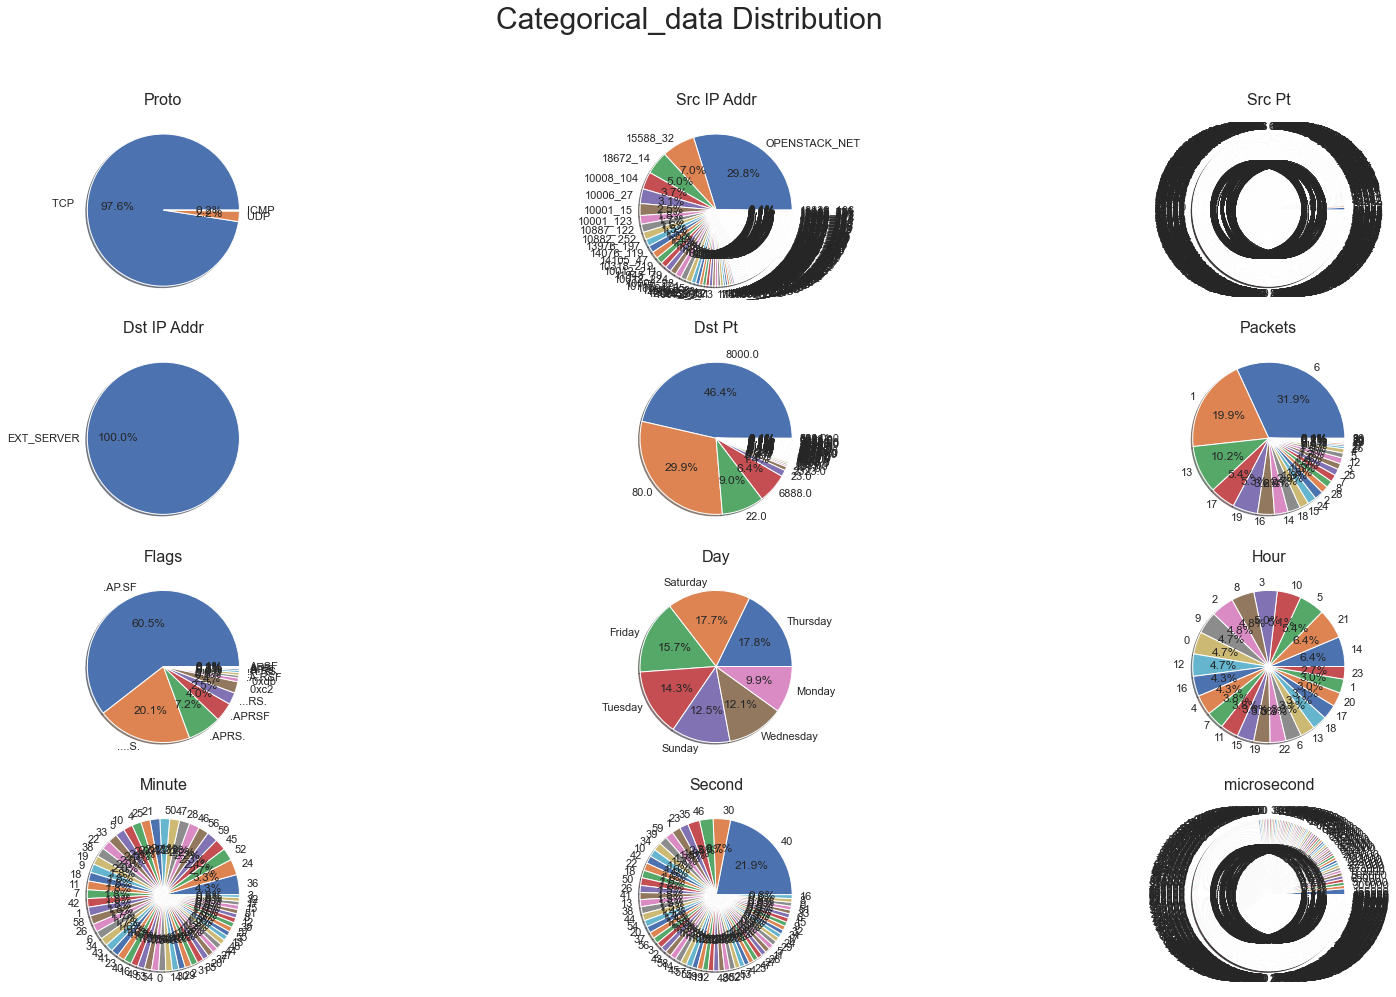

In [841]:
import seaborn as sns
sns.set()
color_random = sns.color_palette()

#select categoricsl data
#categorical_data = df.select_dtypes(include = 'object').dropna()

rows = len(categorical.columns)//3 + np.where(len(categorical.columns)%3 > 0,1,0)
columns= 3

fig, axes = plt.subplots(rows, columns, figsize=(25, 15))
fig.suptitle('Categorical_data Distribution', size=30)

for i in range(1,rows*columns+1):           
    ax=plt.subplot(rows, 3, i)
    if len(categorical.columns) >= i :
       ax.pie(x=categorical[categorical.columns[i-1]].value_counts(),labels= categorical[categorical.columns[i-1]].unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
       plt.title(f'{categorical.columns[i-1]}',size=16,pad=10)
    else:
          break

In [842]:
numerical = sampling.select_dtypes('number')

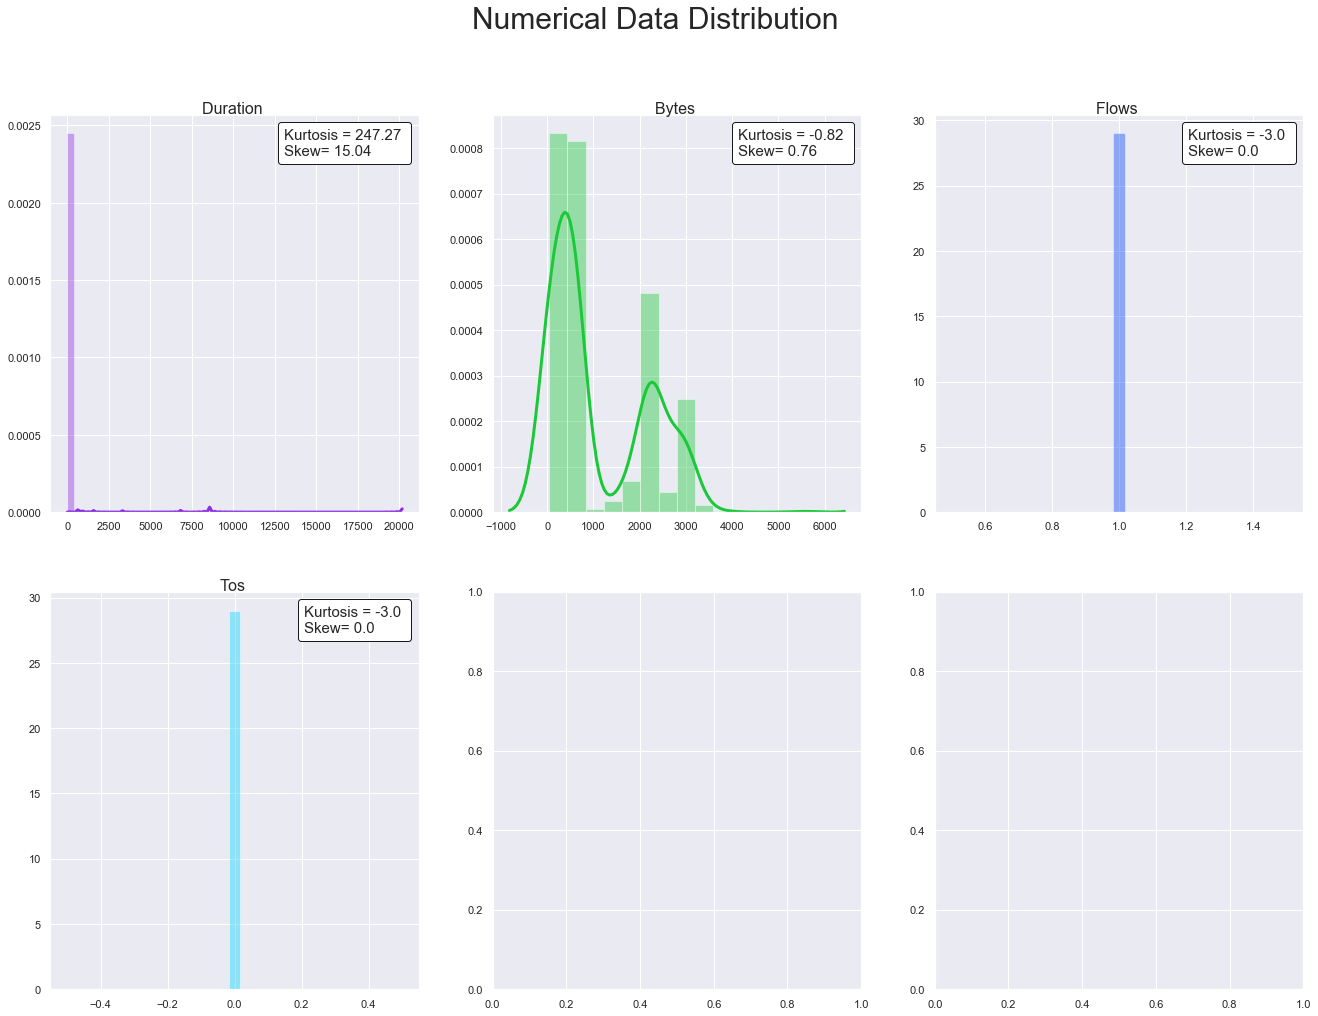

In [843]:
import random
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import AnchoredText
from scipy.stats import kurtosis, skew
sns.set()
color_random = sns.color_palette("bright",10)

#select numerical data
#numerical_data = df.select_dtypes(include = 'number')


rows = len(numerical.columns)//3 + np.where(len(numerical.columns)%3 > 0, 1,0)
columns= 3

fig, axes = plt.subplots(rows, columns, figsize=(20, 15))
fig.suptitle('Numerical Data Distribution', size=30)

for i in range(1,rows*columns+1):
    ax=plt.subplot(rows, 3, i)
    if len(numerical.columns) >= i :
        plt.title(f'{numerical.columns[i-1]} ',size=16,pad=1)
        sns.distplot(
                     numerical[numerical.columns[i-1]], 
                     hist = True, kde = True,axlabel = False,
                     kde_kws = {'linewidth': 3},
                     label = numerical.columns,
                     color = random.choice(color_random)
                     )
        _kurtosis_ = round(kurtosis(numerical[numerical.columns[i-1]]),2)
        _skew_ = round(skew(numerical[numerical.columns[i-1]]),2)
        at = AnchoredText(
                           f"Kurtosis = {_kurtosis_} \nSkew= {_skew_}",
                           prop=dict(size=15), frameon=True,loc='upper right',
                          )
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
    else:
        break

In [844]:
numerical.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Duration,866.0,105.108538,1120.735350,0.0,0.057,6.385,14.998,20160.577
Bytes,866.0,1082.558891,1050.666466,46.0,270.000,586.000,2221.750,5564.000
Flows,866.0,1.000000,0.000000,1.0,1.000,1.000,1.000,1.000
Tos,866.0,0.000000,0.000000,0.0,0.000,0.000,0.000,0.000


**Drop Low variance columns**

In [845]:
df = df.drop(columns=['Flows','Tos'])

**Encoding**

In [846]:
# Frequency Encoding (see module in Annex section)
frequency_encode_table, categorical = Frequency_Encoding().fit_transform(df.select_dtypes('object'))

In [847]:
from sklearn.preprocessing import MinMaxScaler
cateogircal_scale = MinMaxScaler()
categorical_headers = categorical.columns.to_list()
categorical = scale.fit_transform(categorical)
categorical = pd.DataFrame(categorical,columns=categorical_headers)

**Scaling**

In [848]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
numerical_headers = df.select_dtypes('number').columns.to_list()
numerical = scale.fit_transform(df.select_dtypes('number'))
numerical = pd.DataFrame(numerical,columns=numerical_headers)

**Merge scaling, Encoding >>> df**

In [851]:
df= pd.concat([numerical,categorical],axis=1)

In [852]:
df.head()

,Duration,Bytes,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Flags,Day,Hour,Minute,Second,microsecond
0,0.156680,0.117645,1.0,1.0,0.021407,0.0,0.001411,0.0,0.000057,0.639414,0.147635,0.800857,0.007169,0.313869
1,0.156857,0.588234,1.0,1.0,0.009174,0.0,0.001411,0.0,0.000057,0.639414,0.147635,0.800857,0.004595,0.068613
2,0.158004,0.058821,1.0,1.0,0.009174,0.0,0.001411,0.0,0.010021,0.639414,0.268352,0.023555,0.002390,0.017518
3,0.160967,0.058821,1.0,1.0,0.009174,0.0,0.001411,0.0,0.010021,0.639414,0.432300,0.930050,0.005943,0.030657
4,0.166092,0.117645,1.0,1.0,0.006116,0.0,0.001411,0.0,0.010021,0.639414,0.432300,0.126338,0.132284,0.065693


In [853]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Duration,86583.0,0.000262,0.010028,0.0,1.096974e-07,0.000011,0.000032,1.0
Bytes,86583.0,0.000168,0.007124,0.0,8.470611e-06,0.000032,0.000125,1.0
Proto,86583.0,0.975624,0.152761,0.0,1.000000e+00,1.000000,1.000000,1.0
Src IP Addr,86583.0,0.343832,0.423694,0.0,1.386985e-02,0.111120,1.000000,1.0
Src Pt,86583.0,0.019725,0.105017,0.0,3.058104e-03,0.006116,0.009174,1.0
Dst IP Addr,86583.0,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0
Dst Pt,86583.0,0.671033,0.360947,0.0,6.166663e-01,0.616666,1.000000,1.0
Packets,86583.0,0.528768,0.391017,0.0,1.068825e-01,0.687336,1.000000,1.0
Flags,86583.0,0.690962,0.394465,0.0,3.427202e-01,1.000000,1.000000,1.0
Day,86583.0,0.580152,0.361120,0.0,2.107209e-01,0.639414,0.983222,1.0


# Detect Anomaly

### ABOD (Angle Based Outlier Detector)

BOD model considers the relationship between each point and its neighbor(s)

In [854]:
from pyod.models.abod import ABOD
outlier_fraction = 0.1
clf =  ABOD(contamination=outlier_fraction)
clf.fit(df)
ABOD_label = pd.Series(clf.labels_.tolist(),name='ABOD_label') #pd.concat([df,pd.Series(],axis=1).head()
ABOD_score = pd.Series(clf.decision_scores_.tolist(),name='ABOD_score')

In [855]:
ABOD_label.value_counts()

0    77924
1    8659 
Name: ABOD_label, dtype: int64

### Cluster-based Local Outlier Factor

In [856]:
from pyod.models.cblof import CBLOF
outlier_fraction = 0.1
clf = CBLOF(contamination=outlier_fraction,check_estimator=False, random_state=1)
clf.fit(df)
CBLOF_label = pd.Series(clf.labels_.tolist(),name='CBLOF_label')  # binary labels (0: inliers, 1: outliers)
CBLOF_scores = pd.Series(clf.decision_scores_.tolist(),name='CBLOF_scores')  # raw outlier scores

In [857]:
CBLOF_label.value_counts()

0    77924
1    8659 
Name: CBLOF_label, dtype: int64

### Feature Bagging

In [858]:
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lof import LOF
outlier_fraction = 0.1
clf = FeatureBagging(LOF(n_neighbors=35),contamination=outlier_fraction,check_estimator=False,random_state=1)
clf.fit(df)
FeatureBagging_label = pd.Series(clf.labels_.tolist(),name='FeatureBagging_label')  # binary labels (0: inliers, 1: outliers)
FeatureBagging_scores = pd.Series(clf.decision_scores_.tolist(),name='FeatureBagging_scores')  # raw outlier scores

In [859]:
FeatureBagging_label.value_counts()

0    77924
1    8659 
Name: FeatureBagging_label, dtype: int64

### Histogram-base Outlier Detection 

In [860]:
from pyod.models.hbos import HBOS
clf = HBOS(contamination=outlier_fraction)
clf.fit(df)
HBOS_label = pd.Series(clf.labels_.tolist(),name='HBOS_label')  # binary labels (0: inliers, 1: outliers)
HBOS_scores = pd.Series(clf.decision_scores_.tolist(),name='HBOS_scores')  # raw outlier scores

In [861]:
HBOS_label.value_counts()

0    77926
1    8657 
Name: HBOS_label, dtype: int64

### KNN detector

In [862]:
from pyod.models.knn import KNN
clf = KNN()
clf.fit(df)
KNN_label = pd.Series(clf.labels_.tolist(),name='KNN_label')  # binary labels (0: inliers, 1: outliers)
KNN_scores = pd.Series(clf.decision_scores_.tolist(),name='KNN_scores')  # raw outlier scores

In [863]:
KNN_label.value_counts()

0    77924
1    8659 
Name: KNN_label, dtype: int64

### Average KNN

In [864]:
from pyod.models.knn import KNN
clf = KNN(method='mean',contamination=outlier_fraction)
clf.fit(df)
KNN_Avg_label = pd.Series(clf.labels_.tolist(),name='KNN_Avg_label')  # binary labels (0: inliers, 1: outliers)
KNN_Avg_scores = pd.Series(clf.decision_scores_.tolist(),name='KNN_Avg_scores')  # raw outlier scores

In [865]:
KNN_Avg_label.value_counts()

0    77924
1    8659 
Name: KNN_Avg_label, dtype: int64

### Isolation Forest

In [866]:
from pyod.models.iforest import IForest
clf = IForest(contamination=outlier_fraction,random_state=1)
clf.fit(df)
Isolation_Forest_label = pd.Series(clf.labels_.tolist(),name='Isolation_Forest')  # binary labels (0: inliers, 1: outliers)
Isolation_Forest_scores = pd.Series(clf.decision_scores_.tolist(),name='Isolation_Forest')  # raw outlier scores

In [867]:
Isolation_Forest_label.value_counts()

0    77924
1    8659 
Name: Isolation_Forest, dtype: int64

### KMEANS

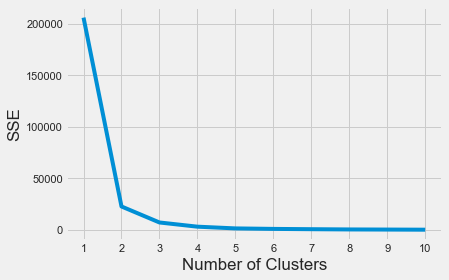

In [868]:
# kmeans cluster optimization

from sklearn.cluster import KMeans,MiniBatchKMeans

kmeans_features = {
     
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}


# Optimise Kmeans
sse = []
for k in range(1, 11):
     kmeans = KMeans(n_clusters=k, **kmeans_features)
     kmeans.fit(df.values.reshape(-1,1))
     sse.append(kmeans.inertia_)
        
        
        
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [869]:
from sklearn.cluster import KMeans
kmeans_features = {'n_clusters': 4,"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}
kmeans = KMeans(**kmeans_features)
kmeans.fit_transform(df.values)
kmeans_label = pd.Series(kmeans.labels_.astype('str').tolist(),name='kmeans')

In [870]:
groups_size = pd.Series(kmeans.labels_.tolist(),name='kmeans').value_counts().sort_index()
groups_centroid = np.mean(kmeans.cluster_centers_,axis=1)

In [871]:
pd.DataFrame(zip(groups_size,groups_centroid.tolist()),columns=['size','centroid'])

,size,centroid
0,28346,0.344911
1,21241,0.250313
2,12759,0.275975
3,24237,0.495560


Calculate the global centroid and distance of each group to global centroid. <br>
Group which far away from global centroid will be the anomly

In [872]:
global_centroid = groups[0]/len(df)*groups_centroid[0]+groups[1]/len(df)*groups_centroid[1]+groups[2]/len(df)*groups_centroid[2]+groups[3]/len(df)*groups_centroid[3]
display(global_centroid)

0.3537161545135774

**Explain: We can see the group 3 far from the center therefore we will asume outliers**

In [873]:
# 1- outliers , 0-inliers
kmeans_label = list(map(lambda x: 1 if int(x) > 2 else 0,kmeans_label))

In [874]:
kmeans_label = pd.Series(kmeans_label,name='kmeans')

### PCA

In [875]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pca = PCA()
pipe = Pipeline(steps=[('pca', pca)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [1,2,3,4,5,10]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(df)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Show Component Variance
#pca.fit(colinear_train)
#print('PCA component Variance=',pca.explained_variance_ratio_)

Best parameter (CV score=5.242):
{'pca__n_components': 10}


In [884]:
# Show Component Variance
PCA(n_components=10).fit(df)
print('PCA component Variance=\n',PCA(n_components=10).fit(df).explained_variance_ratio_)

PCA component Variance=
 [0.38302048 0.19694461 0.11474811 0.07093743 0.06508582 0.05784383
 0.04360885 0.02533378 0.01990282 0.01543842]


**Explain : PCA to complex and can not help us to define  anomaly**

### Ensembling models votes

outliers = score 6-8 <br>
hight_prob= score 4-5 <br>
low_prob = 2-3 <br>
inliers = 0-1

In [885]:
summary = pd.concat([
                     ABOD_label
                    ,CBLOF_label
                    ,FeatureBagging_label
                    ,HBOS_label
                    ,KNN_label
                    ,KNN_Avg_label
                    ,Isolation_Forest_label
                    ,kmeans_label
                   ],axis=1)

In [886]:
summary['score'] = summary.sum(axis=1)
summary = summary.sort_values(by='score',ascending=False)

In [887]:
summary['anomaly_detection'] = summary['score'].apply(lambda x : np.select(condlist=[x<=1,x<=3,x<=5,x<=8]
                                                                           ,choicelist=['inliers','low_prob','high_prob','outliers']))
summary.groupby(['score','anomaly_detection']).size()
summary = summary.sort_index()

# Final Results

In [888]:
summary.anomaly_detection.value_counts()

inliers      68188
low_prob     11615
high_prob    4930 
outliers     1850 
Name: anomaly_detection, dtype: int64

In [889]:
df = pd.concat([df,summary.anomaly_detection],axis=1)
df.head()

,Duration,Bytes,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Flags,Day,Hour,Minute,Second,microsecond,anomaly_detection
0,0.156680,0.117645,1.0,1.0,0.021407,0.0,0.001411,0.0,0.000057,0.639414,0.147635,0.800857,0.007169,0.313869,outliers
1,0.156857,0.588234,1.0,1.0,0.009174,0.0,0.001411,0.0,0.000057,0.639414,0.147635,0.800857,0.004595,0.068613,outliers
2,0.158004,0.058821,1.0,1.0,0.009174,0.0,0.001411,0.0,0.010021,0.639414,0.268352,0.023555,0.002390,0.017518,outliers
3,0.160967,0.058821,1.0,1.0,0.009174,0.0,0.001411,0.0,0.010021,0.639414,0.432300,0.930050,0.005943,0.030657,outliers
4,0.166092,0.117645,1.0,1.0,0.006116,0.0,0.001411,0.0,0.010021,0.639414,0.432300,0.126338,0.132284,0.065693,outliers


# Annex 

**Frequency encoding module**

In [29]:
class Frequency_Encoding:
           
     def __init__ (self):
         self.encoding_table = {}
         self.output = {} 
     
     def fit_transform (self,X_train_categorical):            
         for i in X_train_categorical.columns:   
             frequency_encoding = X_train_categorical.groupby(i).size()/len(X_train_categorical)
             self.encoding_table.update({i:pd.DataFrame(frequency_encoding).reset_index().rename(columns= {i: 'category',0:'Encode'})})
             
             merge = pd.merge(left=X_train_categorical[i],
                      right = self.encoding_table[i], how='left',
                      left_on= i,
                      right_on='category')
            
             self.output.update({i: merge['Encode'].reset_index(drop=True)})             
         return self.encoding_table, pd.DataFrame(self.output)
        
     
     def transform (self,frequency_encode_table,X_test_categorical) :
          for i in X_test_categorical.columns:
               merge = pd.merge(left=X_test_categorical[i],
                      right = frequency_encode_table[i], how='left',
                      left_on= i,
                      right_on='category')
               self.output.update({i: merge['Encode'].reset_index(drop=True)})
          return  pd.DataFrame(self.output)    
     
#X_test_categorical_transform = Frequency_Encoding().transform(frequency_encode_table,X_test_categorical)